In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Input, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("Text_Similarity_Dataset.csv")

In [3]:
# Step 1: Compute TF-IDF Vectors
tfidf = TfidfVectorizer(max_features=5000)  # Set a limit on features to optimize computation
tfidf_matrix1 = tfidf.fit_transform(data['text1'].values)
tfidf_matrix2 = tfidf.transform(data['text2'].values)

# Step 2: Calculate Cosine Similarity
cosine_similarities = cosine_similarity(tfidf_matrix1, tfidf_matrix2).diagonal()

# Step 3: Generate Labels based on a threshold (e.g., 0.5 for high similarity)
threshold = 0.5  # You can adjust this based on your needs
similarity_labels = (cosine_similarities >= threshold).astype(int)
y = similarity_labels

In [4]:
# Parameters
MAX_VOCAB_SIZE = 20000  # Maximum vocabulary size
MAX_SEQUENCE_LENGTH = 100  # Maximum sequence length per text
EMBEDDING_DIM = 100  # Embedding dimensions for each token
NUM_FILTERS = 128  # Number of filters for Conv1D layer
KERNEL_SIZE = 5  # Kernel size for Conv1D
DENSE_UNITS = 64  # Number of units for Dense layer
BATCH_SIZE = 32
EPOCHS = 10

# Step 1: Preprocess the data
texts1 = data['text1'].values
texts2 = data['text2'].values

# Initialize tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(np.concatenate((texts1, texts2)))

# Convert text to sequences
sequences1 = tokenizer.texts_to_sequences(texts1)
sequences2 = tokenizer.texts_to_sequences(texts2)

# Pad sequences
X1 = pad_sequences(sequences1, maxlen=MAX_SEQUENCE_LENGTH)
X2 = pad_sequences(sequences2, maxlen=MAX_SEQUENCE_LENGTH)


# Assuming 'y' is already created based on similarity labels from cosine similarity threshold
# Split the data into 80% training and 20% testing
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.2, random_state=42)


In [5]:
# Step 2: Define the CNN model for text similarity
def create_cnn_model():
    # Input layers
    input_1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
    input_2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

    # Shared embedding layer
    embedding_layer = Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)

    # CNN layer
    conv_layer = Conv1D(NUM_FILTERS, KERNEL_SIZE, activation='relu')
    pooling_layer = GlobalMaxPooling1D()

    # Process first input
    x1 = embedding_layer(input_1)
    x1 = conv_layer(x1)
    x1 = pooling_layer(x1)

    # Process second input
    x2 = embedding_layer(input_2)
    x2 = conv_layer(x2)
    x2 = pooling_layer(x2)

    # Concatenate the outputs
    concatenated = Concatenate()([x1, x2])
    dense_layer = Dense(DENSE_UNITS, activation='relu')(concatenated)
    output = Dense(1, activation='sigmoid')(dense_layer)

    # Define the model
    model = Model(inputs=[input_1, input_2], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# Create and compile the model
model = create_cnn_model()

# Assuming binary similarity labels are available in 'similarity' column (1 for similar, 0 for not)
# Note: Replace `data['similarity'].values` with actual label extraction 
# Now we can use 'similarity_labels' as the labels for training the CNN model

# Train the model on the training data
history = model.fit([X1_train, X2_train], y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

# Evaluate the model on the testing data
test_loss, test_accuracy = model.evaluate([X1_test, X2_test], y_test)
print("Test Accuracy:", test_accuracy)
# history = model.fit([X1, X2], y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10


C:\Users\Laxman\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.9846 - loss: 0.2069 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9972 - loss: 0.0189 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.9982 - loss: 0.0116 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9961 - loss: 0.0201 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.9991 - loss: 0.0059 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.9966 - loss: 0.0131 - val_accuracy: 1.0000 - val_loss: 3.1303e-04
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.9985 - loss: 0.0050 - val_accuracy: 1.0000 - val_loss: 8.3925e-04
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.9984 - loss: 0.0025 - val_accuracy: 1.0000 - va

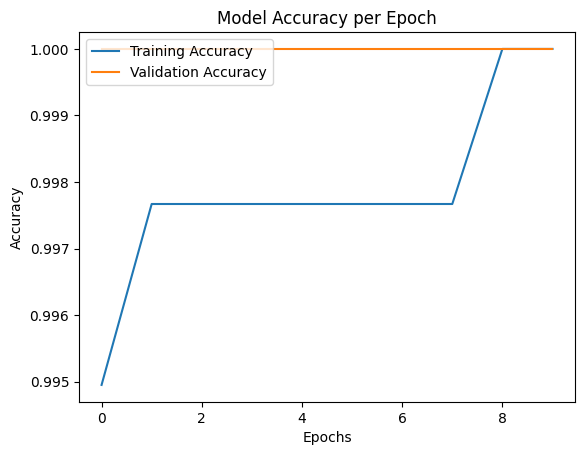

In [7]:
# Using Keras accuracy history for the plot
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training & validation accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

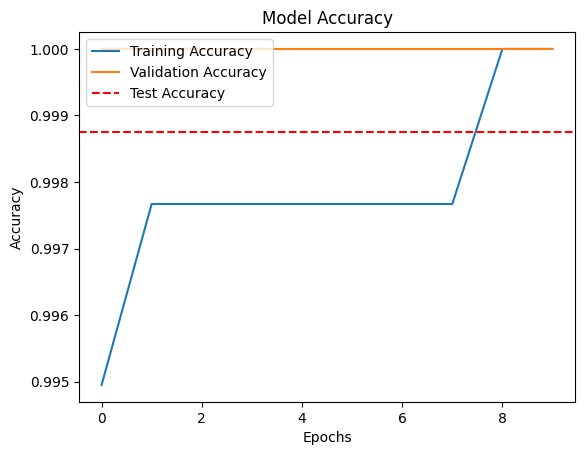

In [8]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()